## Fitbit Calorie Prediction

## Executive Summary

- Built a calorie‑prediction model using Fitbit activity data.
- Improved MAE by 36.7% over baseline using a tuned Random Forest.
- Delivered insights on behavioral drivers of calorie burn and prepared the model for deployment.

## Business Objective

Accurately estimating calorie expenditure is important for:
- Fitness platforms
- Health coaching applications
- Wearable device companies

Reliable calorie predictions improve:
- Personalized recommendations
- User engagement
- Product value

The goal of this project is to develop a machine learning model that predicts daily calories burned using wearable activity metrics such as steps, distance, active minutes, and sedentary time.

We compare multiple models, evaluate performance against a baseline, and identify the most important behavioral drivers influencing calorie burn.

## Modeling Approach

This problem is formulated as a supervised regression task, where the objective is to predict a continuous outcome (calories burned).

We will evaluate:
- Linear Regression
- Ridge Regression
- Random Forest
- Gradient Boosting

Tree-based ensemble models are expected to perform well because they can capture:
- Nonlinear relationships
- Feature interactions
- Complex behavioral patterns

The final model will be optimized using hyperparameter tuning and evaluated on unseen test data.

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

import joblib

## Load Dataset

The dataset contains daily activity metrics collected from Fitbit devices, including steps, distance, active minutes, sedentary time, and calories burned.

In [2]:
df = pd.read_csv("dailyActivity_merged.csv")
print("Dataset Shape:", df.shape)
df.head()

Dataset Shape: (940, 15)


,Id,ActivityDate,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories
0,1503960366,4/12/2016,13162,8.50,8.50,0.0,1.88,0.55,6.06,0.0,25,13,328,728,1985
1,1503960366,4/13/2016,10735,6.97,6.97,0.0,1.57,0.69,4.71,0.0,21,19,217,776,1797
2,1503960366,4/14/2016,10460,6.74,6.74,0.0,2.44,0.40,3.91,0.0,30,11,181,1218,1776
3,1503960366,4/15/2016,9762,6.28,6.28,0.0,2.14,1.26,2.83,0.0,29,34,209,726,1745
4,1503960366,4/16/2016,12669,8.16,8.16,0.0,2.71,0.41,5.04,0.0,36,10,221,773,1863


## Data Preparation and Feature Engineering

We select relevant activity variables and engineer a feature representing total active minutes across intensity levels.

In [3]:
df = df[
    [
        "TotalSteps",
        "TotalDistance",
        "VeryActiveMinutes",
        "FairlyActiveMinutes",
        "LightlyActiveMinutes",
        "SedentaryMinutes",
        "Calories",
    ]
]

# Create total active minutes
df["TotalActiveMinutes"] = (df["VeryActiveMinutes"] + df["FairlyActiveMinutes"] + df["LightlyActiveMinutes"])

# Drop redundant columns
df = df.drop(columns=["VeryActiveMinutes", "FairlyActiveMinutes", "LightlyActiveMinutes"])

df.head()

,TotalSteps,TotalDistance,SedentaryMinutes,Calories,TotalActiveMinutes
0,13162,8.50,728,1985,366
1,10735,6.97,776,1797,257
2,10460,6.74,1218,1776,222
3,9762,6.28,726,1745,272
4,12669,8.16,773,1863,267


## Exploratory Data Analysis

We explore relationships between activity metrics and calorie expenditure to understand which variables may be strong predictors.

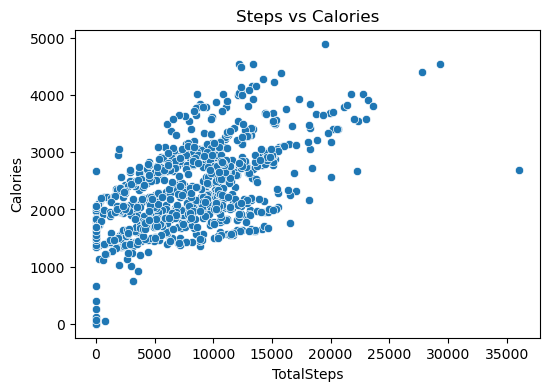

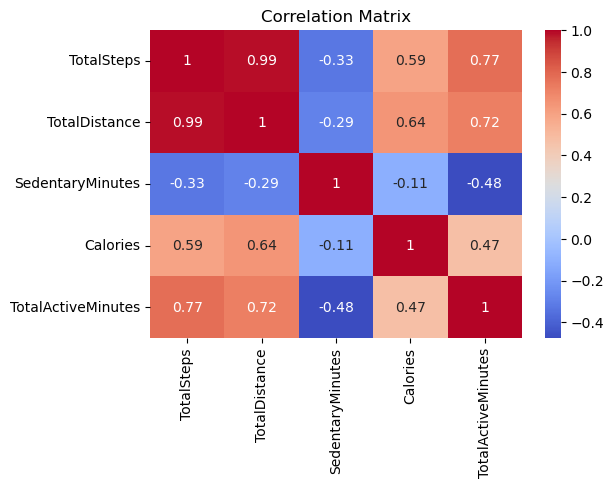

In [4]:
plt.figure(figsize=(6,4))
sns.scatterplot(x="TotalSteps", y="Calories", data=df)
plt.title("Steps vs Calories")
plt.show()

plt.figure(figsize=(6,4))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

## Train-Test Split

The dataset is split into training and testing sets to evaluate model performance on unseen data.

In [5]:
X = df.drop("Calories", axis=1)
y = df["Calories"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## Baseline Model

A baseline model using the average calories provides a reference point to determine whether machine learning models add predictive value.

In [6]:
baseline_pred = np.full(len(y_test), y_train.mean())
baseline_mae = mean_absolute_error(y_test, baseline_pred)
print("Baseline MAE:", baseline_mae)

Baseline MAE: 552.2655330466275


## Model Training and Evaluation

We train multiple models to compare performance against the baseline.

## Linear Regression Model

In [7]:
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)
lin_preds = lin_model.predict(X_test)

lin_mae = mean_absolute_error(y_test, lin_preds)
lin_rmse = np.sqrt(mean_squared_error(y_test, lin_preds))
lin_r2 = r2_score(y_test, lin_preds)

print("Linear Regression")
print("MAE:", lin_mae, "RMSE:", lin_rmse, "R2:", lin_r2)

Linear Regression
MAE: 414.0916169216509 RMSE: 514.0933159469637 R2: 0.44085784581041587


## Ridge Regression Model

In [8]:
ridge_model = Ridge()
ridge_model.fit(X_train, y_train)
ridge_preds = ridge_model.predict(X_test)

ridge_mae = mean_absolute_error(y_test, ridge_preds)
ridge_rmse = np.sqrt(mean_squared_error(y_test, ridge_preds))
ridge_r2 = r2_score(y_test, ridge_preds)

print("Ridge Regression")
print("MAE:", ridge_mae, "RMSE:", ridge_rmse, "R2:", ridge_r2)

Ridge Regression
MAE: 414.2287364076884 RMSE: 514.1487774828773 R2: 0.44073719629226393


## Random Forest Model

In [9]:
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

rf_mae = mean_absolute_error(y_test, rf_preds)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_preds))
rf_r2 = r2_score(y_test, rf_preds)

print("Random Forest")
print("MAE:", rf_mae, "RMSE:", rf_rmse, "R2:", rf_r2)

Random Forest
MAE: 350.0000720153135 RMSE: 472.5106212400487 R2: 0.527652663359418


## Gradient Boosting Model

In [10]:
gb_model = GradientBoostingRegressor(random_state=42)
gb_model.fit(X_train, y_train)
gb_preds = gb_model.predict(X_test)

gb_mae = mean_absolute_error(y_test, gb_preds)
gb_rmse = np.sqrt(mean_squared_error(y_test, gb_preds))
gb_r2 = r2_score(y_test, gb_preds)

print("Gradient Boosting")
print("MAE:", gb_mae, "RMSE:", gb_rmse, "R2:", gb_r2)

Gradient Boosting
MAE: 360.3146434016913 RMSE: 484.52940374547535 R2: 0.5033178007964694


## Model Comparison

We compare all models against the baseline to determine which approach provides the greatest predictive improvement.

In [11]:
results = pd.DataFrame({
    "Model": ["Baseline", "Linear", "Ridge", "Random Forest", "Gradient Boosting"],
    "MAE": [baseline_mae, lin_mae, ridge_mae, rf_mae, gb_mae],
    "RMSE": [None, lin_rmse, ridge_rmse, rf_rmse, gb_rmse],
    "R2": [None, lin_r2, ridge_r2, rf_r2, gb_r2]
})

results.sort_values("MAE")

,Model,MAE,RMSE,R2
3,Random Forest,350.000072,472.510621,0.527653
4,Gradient Boosting,360.314643,484.529404,0.503318
1,Linear,414.091617,514.093316,0.440858
2,Ridge,414.228736,514.148777,0.440737
0,Baseline,552.265533,NaN,NaN


The Random Forest model achieved the strongest performance compared to
linear models and baseline prediction.

## Hyperparameter Tuning

We tune the Random Forest model using GridSearchCV to further improve predictive accuracy.

In [12]:
param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 5, 10, 20],
    "min_samples_split": [2, 5, 10]
}

rf = RandomForestRegressor(random_state=42)
grid = GridSearchCV(rf, param_grid, cv=5, scoring="neg_mean_absolute_error", n_jobs=-1)
grid.fit(X_train, y_train)

print("Best Parameters:", grid.best_params_)
best_model = grid.best_estimator_

Best Parameters: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 300}


## Cross-Validation 
GridSearchCV already used 5-fold CV for hyperparameter tuning. This separate CV confirms that the chosen model is stable and performs consistently across different training splits.

In [13]:
cv_scores = cross_val_score(
    best_model,
    X_train,
    y_train,
    cv=5,
    scoring="neg_mean_absolute_error"
)

print("Cross-Validated MAE:", -cv_scores.mean())

Cross-Validated MAE: 341.88254627850205


## Final Test Evaluation

In [14]:
final_preds = best_model.predict(X_test)
final_mae = mean_absolute_error(y_test, final_preds)
final_rmse = np.sqrt(mean_squared_error(y_test, final_preds))
final_r2 = r2_score(y_test, final_preds)

print("Final Model Performance on Test Data")
print("MAE:", final_mae, "RMSE:", final_rmse, "R2:", final_r2)

improvement = (baseline_mae - final_mae) / baseline_mae * 100
print(f"MAE Improvement Over Baseline: {improvement:.2f}%")

Final Model Performance on Test Data
MAE: 349.3770577582042 RMSE: 472.33425049612873 R2: 0.528005217141123
MAE Improvement Over Baseline: 36.74%


## Residual Analysis
Residual Diagnostics help evaluate model bias and error patterns

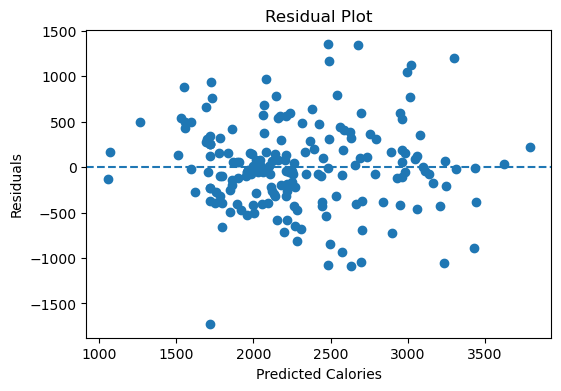

In [15]:
residuals = y_test - final_preds

plt.figure(figsize=(6,4))
plt.scatter(final_preds, residuals)
plt.axhline(0, linestyle="--")
plt.xlabel("Predicted Calories")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

## Feature Importance

Understanding which behaviors most influence calorie burn can provide actionable insights for fitness platforms and users.

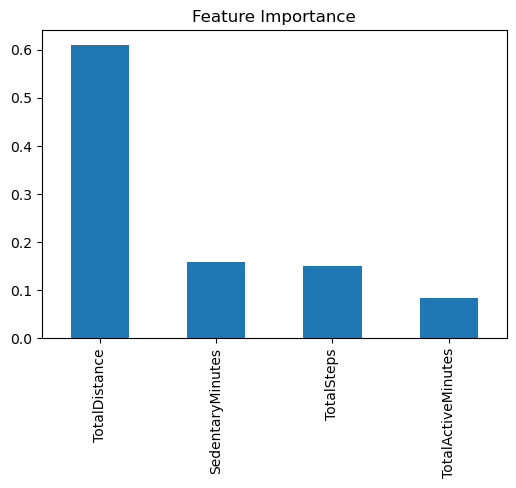

In [16]:
importances = pd.Series(best_model.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(6,4))
importances.plot(kind="bar")
plt.title("Feature Importance")
plt.show()

## Key Insights

- Total distance traveled was the strongest predictor of calorie expenditure.
- Activity-related features (steps and active minutes) were positively associated with calorie burn.
- Sedentary time showed an inverse relationship with calories, indicating reduced energy expenditure during inactive periods.

These findings align with physiological expectations and demonstrate the value of wearable activity data for personalized health analytics.

## Model Deployment
The trained model is saved for future use or deployment

In [17]:
joblib.dump(best_model, "fitbit_calorie_model.pkl")

['fitbit_calorie_model.pkl']

## Limitations
- Fitbit data is device-estimated; may have measurement errors.
- No demographic or physiological features (age, weight, gender).
- Aggregated daily data loses temporal patterns.

## Next Steps
- Try XGBoost or LightGBM for potentially better performance.
- Add time-series features or session-level activity data.
- Build an API for deployment to a web or mobile app.

## Conclusion

This project demonstrates an end-to-end machine learning workflow including:
- Data preparation and feature engineering
- Exploratory analysis
- Baseline modeling
- Model comparison and hyperparameter tuning
- Cross-validation
- Model interpretation
- Residual diagnostics
- Deployment preparation

The final model significantly improved prediction accuracy compared to the baseline, reducing error by a substantial margin.

These results show that wearable activity data can be used to generate meaningful calorie predictions, supporting applications in fitness tracking platforms, health coaching tools, and digital health products.